In [5]:
%load_ext autoreload
%matplotlib inline  
%reload_ext autoreload
__author__ = 'ewan'
import numpy as np
import sys
sys.path.append("../src/") 
import matplotlib.pyplot as plt
import fusedwake.WindFarm as wf # Fusedwake wind farm model from JUAN
import fusedwake.WindTurbine as wt # Fusedwake wind turbine model from JUAN
import pandas as pd
from fusedwake.sdwm.DWM_GClarsenPicks import get_Rw
from fusedwake.sdwm.DWM_misc import LoadOutputs, my_rolling_deg

print '************* Post process wind farm efficiency ***************** '

WTG='GenericSWT2_3'
WS = 9.0;TI = 0.06;WTcoord='../data/Lill_full.dat'; WTspec='../WT-data/'+WTG+'/'+WTG+'_PC.dat'; HH=65.0; R=46.5; stab='N';
WT = wt.WindTurbine('Generic turbine similar to Siemens from Lillgrund',WTspec,65,46.5)
WF = wf.WindFarm('Lillgrund',WTcoord,WT)
vWD = np.arange(0.,360.,1)
mech_to_elec=0.94 # obtained from comparing BEM results mech power and official electrical power curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
************* Post process wind farm efficiency ***************** 


In [6]:
# Dominant wake superposition
folder='../data/LillgrundEfficiency/sDWM/Dominant/'
powers, ref_powers = LoadOutputs(folder,vWD,WF,WS,TI)
powers_dominant=sum(powers)
dwm_dominant= pd.DataFrame({'wd':vWD, 'power':powers_dominant})
nom_power=WT.get_P(WS)
dwm_dominant['eff'] = dwm_dominant['power'] / (nom_power * WF.nWT)

## NEED TO APPLY A 3DEG MOVING AVERAGE TO THE RESULTS
# Meas. by Kurt
df_data = pd.read_csv('../data/LillgrundEfficiency/Meas-Kurt/efficiency.dat', sep= '\s*', engine= 'python')
df_data['eff'] /= 100.

# Perform rolling average as in Gaumont et al.
dwm_dominant_avg = my_rolling_deg(dwm_dominant,dwd=5.)

/Users/pe/.virtualenvs/fusedwake/lib/python2.7/site-packages/scipy/integrate/quadpack.py:352: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [7]:
gcl=np.load('../data/LillgrundEfficiency/Multifidelity-pire/df_gcl_avg.npy')
noj=np.load('../data/LillgrundEfficiency/Multifidelity-pire/df_noj_avg.npy')
rans=np.load('../data/LillgrundEfficiency/Multifidelity-pire/df_rans_avg.npy')

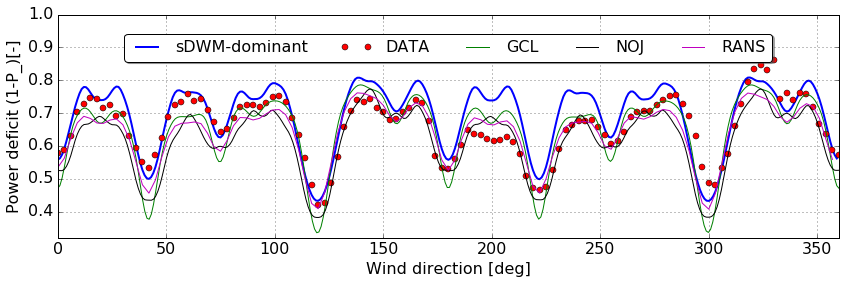

In [20]:
plt.figure(figsize=(14, 4))
sdwm,=plt.plot(dwm_dominant_avg['wd'],dwm_dominant_avg['eff']*mech_to_elec,'b-',linewidth=2,label='sDWM-dominant')
plt.hold('True')
scada,=plt.plot(df_data['wd'],df_data['eff'],'ro',label='DATA',linewidth=2)
gclp,=plt.plot(gcl[:,1], gcl[:,0],'g-',label='GCL',linewidth=1)
nojp,=plt.plot(noj[:,1], noj[:,0],'k-',label='NOJ',linewidth=1)
ransp,=plt.plot(rans[:,1], rans[:,0],'m-',label='RANS',linewidth=1)
plt.ylim((0.32,1,))
# plt.ylim((0.,1.))
plt.xlim((0,360))
plt.grid('on')
plt.xlabel('Wind direction [deg]',fontsize=16)
plt.ylabel('Power deficit (1-P_)[-]',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(handles=[sdwm, scada, gclp, nojp, ransp],loc='upper center', bbox_to_anchor=(0.5, 0.95),
          fancybox=True, shadow=True, ncol=5,fontsize=16)


In [19]:
## Dominant sDWM
folder='../data/LillgrundEfficiency/sDWM/Dominant'      
#folder='../../DWMpython/outputs/DominantJan2016/'
powers, ref_powers = LoadOutputs(folder, vWD, WF, WS, TI)
dwm_22= pd.DataFrame({'wd':vWD, 'power':powers[22,:]})
powers_avg = my_rolling_deg(dwm_22, x='wd', y='power',dwd=5.)


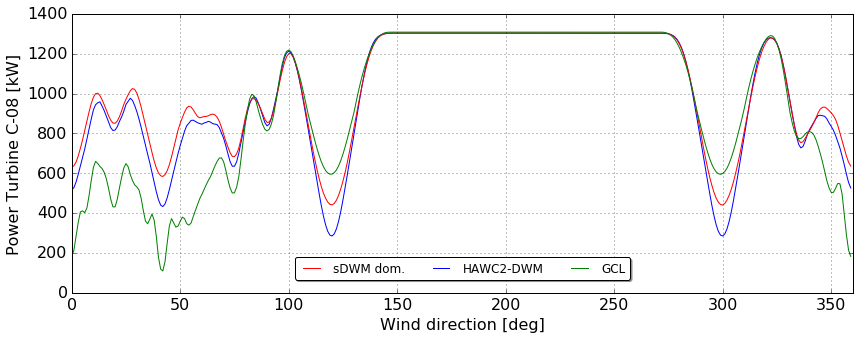

In [22]:
# Comparison with HAWC2DWM on turbine 22 (C08) not full polar
import numpy as np
y=np.load('../data/LillgrundEfficiency/HAWC2-DWM/polar9ms_free_Pe.npy')
y[:,0]=y[:,0]%360
y=y[y[:,0].argsort()]
gcl_powers=np.load('../data/LillgrundEfficiency/Multifidelity-pire/gcl_powers.npy')
plt.figure(figsize=(14, 5))
hdwm,=plt.plot(y[:,0],y[:,1],'b-',label='HAWC2-DWM')
plt.hold('True')
sdwm,=plt.plot(vWD,powers_avg['power']*mech_to_elec,'r-',linewidth=1,label='sDWM dom.')
gclp,=plt.plot(vWD,gcl_powers[:,21],'g-',label='GCL')
plt.xlim((0,360))
plt.grid('on')
plt.xlabel('Wind direction [deg]',fontsize=16)
plt.ylabel('Power Turbine C-08 [kW]',fontsize=16)
plt.tick_params(axis='both',labelsize=16)

plt.legend(handles=[sdwm, hdwm, gclp],loc='upper center', bbox_to_anchor=(0.5, +0.15),
          fancybox=True, shadow=True, ncol=5)


    207   212   217   222   227   232  237 
0   456   426   462   396   369   365   399
1   435   462   491   410   409   380   398
2   469   526   518   438   431   414   424
3   588   645   534   475   565   548   489
4   964   822   588   508   569   644   583
5  1114   940   683   587   625   873   896
6  1134   906   583   477   635  1034  1285
7  1352  1357  1367  1365  1372  1374  1378


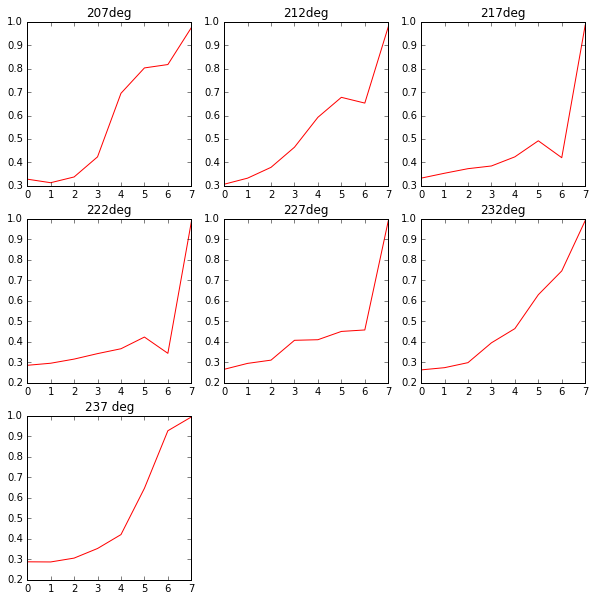

In [8]:
# Comparison with other stuff
df222 = pd.read_csv('../data/LillgrundEfficiency/Meas-Kurt/neutral_222.dat', sep='\t')
print df222
ws = 9.0
plt.figure(figsize=(10,10))
for i, sd in enumerate(df222.keys()):
    plt.subplot(3,3,i+1)
    plt.plot(df222[sd][::-1]/WT.get_P(WS), color='red')
    plt.title(str(sd)+'deg')


No annotation of turbines


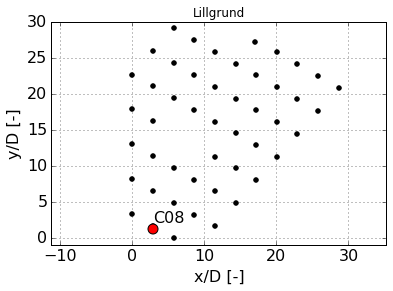

In [9]:
# print ID_wake
plt.figure(figsize=(25, 25))
fig,ax=WF.plot(WT_num=False)
fig.hold('True')
ax.scatter(2.85,1.15,c='red',s=100)
plt.text(2.85,2.15,'C08',fontsize=16)
# plt.xlim((0,360))
plt.ylim((-1,30))
plt.xlim((-1,25))
plt.xlabel('x/D [-]',fontsize=16)
plt.ylabel('y/D [-]',fontsize=16)
plt.tick_params(axis='both',labelsize=16)
plt.grid('on')
# plt.savefig('Figs/C08sketch.png',bbox_inches='tight')
# plt.savefig('Figs/C08sketch.pdf',bbox_inches='tight')